In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [2]:
data = []

pattern = r'Configuration: \{"goal": "(?P<goal>\w+)(?: \((?P<negotiation>.*?)\))?"[^}]*\}. Negotiation time: (?P<time>\d+\.\d+) seconds. Rounds: (?P<rounds>\d+). Result: (?P<result>\S+)'

sim_files = [os.path.join('../results', f) for f in os.listdir('../results') if f.startswith('simulation-')] # and (f.endswith('2.log') or f.endswith('pc.log'))]

for log_file_path in sim_files:
    with open(log_file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                context = "airport" if match.group("goal") == "navigate_to_gate" else "hospital"
                negotiation = match.group("negotiation")
                rounds = int(match.group("rounds")) // 2 + (int(match.group("rounds")) % 2 > 0)
                time = float(match.group("time"))
                result = match.group("result")
                setting = "offrobot" if "offrobot" in log_file_path else "onrobot"
                data.append({"negotiation": negotiation, "rounds": rounds, "negotiation_time": time, "result": result, "context": context, "deployment": setting})

df = pd.DataFrame(data)
df.head()

,negotiation,rounds,negotiation_time,result,context,deployment
0,"User: A, Negotiating against: B",5,0.568,no-agreement,hospital,onrobot
1,"User: A, Negotiating against: C",7,0.682,no-agreement,hospital,onrobot
2,"User: A, Negotiating against: D",8,0.742,loser,hospital,onrobot
3,"User: A, Negotiating against: E",8,0.783,loser,hospital,onrobot
4,"User: A, Negotiating against: F",5,0.578,loser,hospital,onrobot


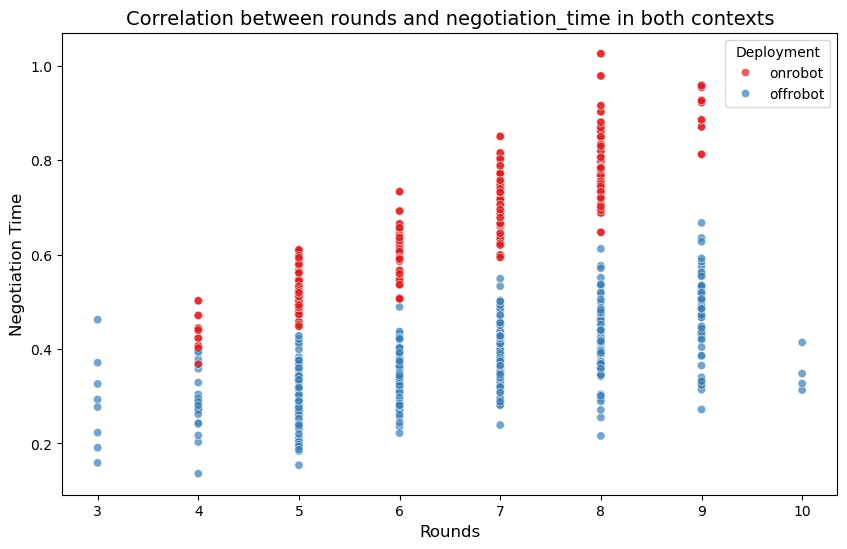

In [3]:
plt.figure(figsize=(10, 6))

plotting_df = df

sns.scatterplot(data=plotting_df, x='rounds', y='negotiation_time', hue='deployment', palette='Set1', alpha=0.7)

plt.title("Correlation between rounds and negotiation_time in both contexts", fontsize=14)
plt.xlabel("Rounds", fontsize=12)
plt.ylabel("Negotiation Time", fontsize=12)
plt.legend(title="Deployment", fontsize=10)

plt.show()

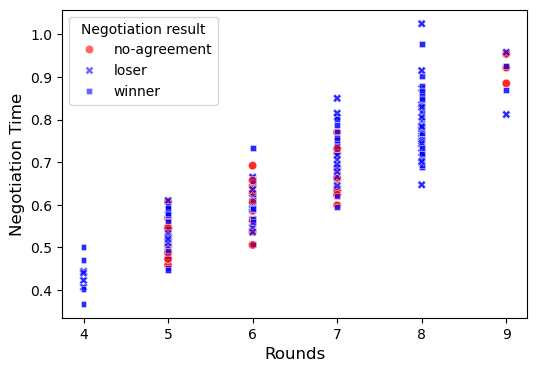

In [4]:
plt.figure(figsize=(6, 4))

onrobot_df = df[df['deployment'] == 'onrobot']

sns.scatterplot(data=onrobot_df, x='rounds', y='negotiation_time', hue='result', style='result', palette={'no-agreement': 'red', 'winner': 'blue', 'loser': 'blue'}, alpha=0.6)

plt.xlabel("Rounds", fontsize=12)
plt.ylabel("Negotiation Time", fontsize=12)
plt.legend(title="Negotiation result", fontsize=10)

plt.show()


In [6]:
# Stats
overall_stats = df.groupby('deployment').agg({
    'negotiation_time': ['mean', 'min', 'max', 'std']
})
print("Overall statistics for negotiation time by deployment:")
print(overall_stats)

airport_stats = df[df['context']=='airport'].groupby('deployment').agg({
    'negotiation_time': ['mean', 'min', 'max', 'std']
})
print("\n\n\nAirport context:")
print(airport_stats)

hospital_stats = df[df['context']=='hospital'].groupby('deployment').agg({
    'negotiation_time': ['mean', 'min', 'max', 'std']
})
print("\n\n\nHospital context:")
print(hospital_stats)


Overall statistics for negotiation time by deployment:
           negotiation_time                        
                       mean    min    max       std
deployment                                         
offrobot           0.369203  0.136  0.667  0.096771
onrobot            0.661667  0.368  1.025  0.135595



Airport context:
           negotiation_time                        
                       mean    min    max       std
deployment                                         
offrobot           0.358322  0.136  0.635  0.087307
onrobot            0.661667  0.368  1.025  0.135784



Hospital context:
           negotiation_time                        
                       mean    min    max       std
deployment                                         
offrobot           0.380083  0.154  0.667  0.104503
onrobot            0.661667  0.368  1.025  0.135784


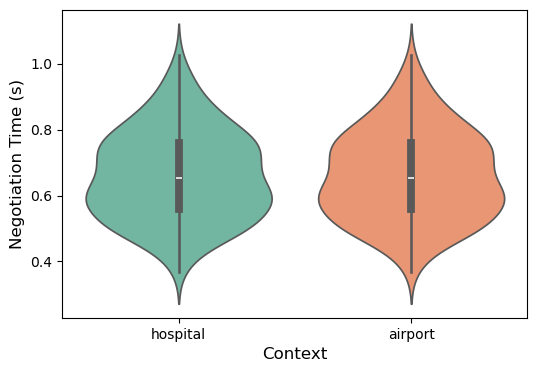

In [7]:
plt.figure(figsize=(6, 4))

onrobot_df = df[df['deployment'] == 'onrobot']

sns.violinplot(data=onrobot_df, x='context', y='negotiation_time', hue="context", palette='Set2')

plt.xlabel("Context", fontsize=12)
plt.ylabel("Negotiation Time (s)", fontsize=12)

plt.show()

In [8]:
long_negotiations = onrobot_df[onrobot_df['negotiation_time'] > 0.8]

num_long_negotiations = long_negotiations.shape[0]

total_onrobot_cases = onrobot_df.shape[0]
percentage_long_negotiations = (num_long_negotiations / total_onrobot_cases) * 100

print(f"Negotiation completed in more than 0.8 seconds: {num_long_negotiations}")
print(f"Percentage: {percentage_long_negotiations:.2f}%")
print("\nCases:")
print(long_negotiations)

Negotiation completed in more than 0.8 seconds: 60
Percentage: 16.67%

Cases:
                         negotiation  rounds  negotiation_time        result  \
20   User: C, Negotiating against: D       8             0.873         loser   
21   User: C, Negotiating against: E       8             0.835         loser   
23   User: C, Negotiating against: G       7             0.850         loser   
24   User: C, Negotiating against: H       7             0.806         loser   
27   User: D, Negotiating against: A       8             0.850        winner   
28   User: D, Negotiating against: B       8             0.864        winner   
29   User: D, Negotiating against: C       8             0.902        winner   
30   User: D, Negotiating against: E       9             0.956  no-agreement   
31   User: D, Negotiating against: F       8             0.819        winner   
32   User: D, Negotiating against: G       8             0.861        winner   
33   User: D, Negotiating against: H      

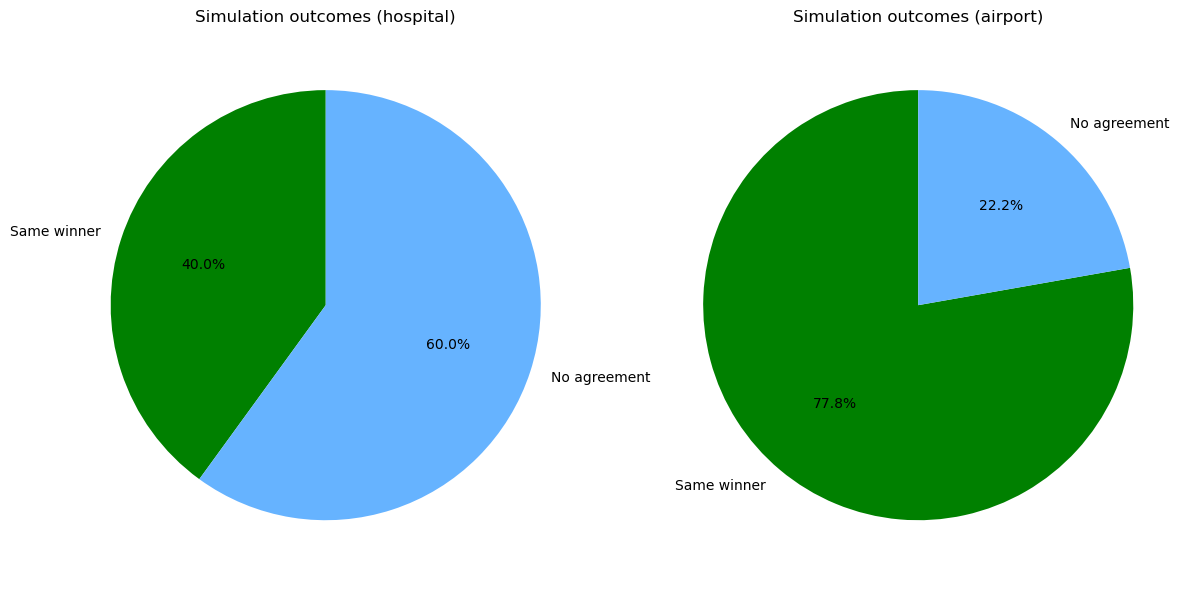

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for idx, ctx in enumerate(['hospital', 'airport']):
    #ctx_df = onrobot_df[onrobot_df['context'] == ctx]
    ctx_df = df[(df['context'] == ctx) & (df['deployment'] == 'offrobot')]
    result_count = ctx_df[ctx_df['result'] != 'no-agreement'].shape[0]
    total_count = ctx_df.shape[0]

    sizes = [result_count, total_count - result_count]

    axes[idx].pie(sizes, labels=['Same winner', 'No agreement'], colors=['green', '#66b3ff'], autopct='%1.1f%%', startangle=90)
    axes[idx].set_title(f'Simulation outcomes ({ctx})')
    axes[idx].axis('equal')

plt.tight_layout()
plt.show()

In [10]:
no_agreement_df = onrobot_df[(onrobot_df['result'] == 'no-agreement')]
winner_loser_df = onrobot_df[(onrobot_df['result'].isin(['winner', 'loser']))]

complete_stats = onrobot_df['negotiation_time'].describe()

no_agreement_stats = no_agreement_df['negotiation_time'].describe()

winner_loser_stats = winner_loser_df['negotiation_time'].describe()

print("Overall stats:")
print(complete_stats)

print("\nWhen negotiation ends with agreement:")
print(winner_loser_stats)

print("\nWhen no agreement is reached:")
print(no_agreement_stats)


Overall stats:
count    360.000000
mean       0.661667
std        0.135595
min        0.368000
25%        0.560500
50%        0.652000
75%        0.758500
max        1.025000
Name: negotiation_time, dtype: float64

When negotiation ends with agreement:
count    280.000000
mean       0.670907
std        0.136899
min        0.368000
25%        0.566000
50%        0.682000
75%        0.773750
max        1.025000
Name: negotiation_time, dtype: float64

When no agreement is reached:
count    80.000000
mean      0.629325
std       0.126496
min       0.458000
25%       0.540000
50%       0.615500
75%       0.681250
max       0.956000
Name: negotiation_time, dtype: float64
